# PyStan demo: Normal mean estimation

This notebook performs a Stan fit to simulated data from a normal distribution,
estimating the mean with a normal prior/normal sampling dist'n model.  It prints
summaries of the posterior to the terminal, and plots two figures showing
traceplots (of the posterior mean and the log density) and an estimated
posterior PDF (blue curve) along with the analytical PDF (green dashed curve).

Three statistical tests are run, with results printed to the terminal.  They
will occasionally fail even with a sound installation, but this should happen
only rarely.

**Windows users:**  This example presumes Windows users are using
PyStan-2.19+ with Py-3.  Earlier versions did not support parallel
computing (running separate chains in separate jobs), and PyStan-2.19
only supports parallel computing with Py-3 (and presently this support
appears to be unreliable).

I strongly recommend using conda to install a current Anaconda Python-3
environment, with PyStan installed via `conda install pystan` (i.e., not using
the `pip` installer recommended in PyStan's documentation).  This will
install a version of the C++ compiler needed by PyStan, and ensure it is
compatible with conda's Python installation.


Created Apr 16, 2015 by Tom Loredo  
2020-04-17:  Modified for Py-3 and BDA20; converted to Jupyter notebook

These are needed to handle Windows limitations.

In [1]:
import sys
import platform

The usual imports and plotting setup, plus `pystan`.

In [2]:
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib.pyplot import *
from numpy import *
from scipy import stats

import pystan
from timer import Timer

This code is to handle a parallel jobs limitation under Windows. Stan can sample from multiple copies of a Markov chain in parallel, dispatching chains to separate cores. Prior to PyStan-2.19, parallel computation was unavailable under Windows. In PyStan-2.19, parallel computing is *allegedly* supported for Windows 10 with Python-3 (but not Python-2). However, as of 2020-04-17 (with the lastest Anaconda and Windows 10 updates), PyStan fails when attempting to use multiple cores under Windows. This notebook detects whether it is being run under Windows and disable parallel computing in that case.

Note `n_jobs = -1` indicates to use all available cores.

In [3]:
py_major = sys.version[:1]
if platform.system() == 'Windows':
    if py_major == '3':
        n_jobs = 1  # docs say this can be -1, but it fails as of 2020-04-17
    else:
        n_jobs = 1
else:
    n_jobs = -1  # supported by macOS, Linux

Stan code for a conjugate normal-normal model with unknown mean:

In [4]:
normal_mu_code = """
data {
    int<lower=0> N; // number of samples
    real y[N]; // samples
}
parameters {
    real mu;
}
model {
    mu ~ normal(0, 10.);  // prior is a wide normal
    for (i in 1:N) {
        y[i] ~ normal(mu, 1.);  // sampling dist'n
    }
}
"""

Sampling dist'n for data from a unit-standard-deviation normal with mean `mu`:

In [5]:
# Sampling dist'n for data from a unit-sigma normal @ mu:
mu = 5.
samp_distn = stats.norm(mu, 1.)

# Simulate data:
N = 100
yvals = samp_distn.rvs(N)

Analytical posterior for conjugate normal-normal:

In [6]:
mu0 = 0.  # prior mean
w0 = 10.  # prior width
w = 1. / sqrt(N)  # likelihood width
ybar = mean(yvals)  # likelihood location
B = w**2 / (w**2 + w0**2)  # shrinkage factor
mu_post = ybar + B * (mu0 - ybar)
sig_post = w * sqrt(1. - B)
post_pdf = stats.norm(mu_post, sig_post)

**Compile the Stan code:** This is a bit time-consuming (which can make debugging somewhat painful). Here, we do the compilation using a `Timer` context manager provided in the [`timer` module](./timer.py). For more on context managers and Python's `with` statement, see [The `with` statement — Python 3.8.2 documentation](https://docs.python.org/3/reference/compound_stmts.html#the-with-statement) and [a `with` statement tutorial](https://www.pythonforbeginners.com/files/with-statement-in-python).

***NOTE:*** Watch the terminal running the notebook server, both when compiling Stan code and later, when using the resulting Stan model to fit data. Stan prints some information to the terminal, including compilation errors and sampling progress.

In [7]:
with Timer(quiet=False) as timer:
    model = pystan.StanModel(model_code=normal_mu_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_921ca5e04eb4a1d3211626dc8d6fb123 NOW.
clang-11: warning: -Wl,-export_dynamic: 'linker' input unused [-Wunused-command-line-argument]
In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_r3h59wku/stanfit4anon_model_921ca5e04eb4a1d3211626dc8d6fb123_7272352720295059345.cpp:777:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_r3h59wku/stanfit4anon_model_921ca5e04eb4a1d3211626dc8d6fb123_7272352720295059345.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_r3h59wku/stanfit4anon_model_921ca5e04eb4a1d3211626dc8d6fb123_7272352720295059345.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_r3h59wku/stanfit4anon_model_921ca5e04eb4a1d3211626dc8d6fb123_7272352720295059345.cpp:787:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function 'boost::random::linear_

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_r3h59wku/stanfit4anon_model_921ca5e04eb4a1d3211626dc8d6fb123_7272352720295059345.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_r3h59wku/stanfit4anon_model_921ca5e04eb4a1d3211626dc8d6fb123_7272352720295059345.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_r3h59wku/stanfit4anon_model_921ca5e04eb4a1d3211626dc8d6fb123_7272352720295059345.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_r3h59wku/stanfit4anon_model_921ca5e04eb4a1d3211626dc8d6fb123_7272352720295059345.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_r3h59wku/stanfit4anon_model_921ca5e04eb4a1d3211626dc8d6fb123_7272352720295059345.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_r3h59wku/stanfit4anon_model_921ca5e04eb4a1d3211626dc8d6fb123_7272352720295059345.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_r3h59wku/stanfit4anon_model_921ca5e04eb4a1d3211626dc8d6fb123_7272352720295059345.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_r3h59wku/stanfit4anon_model_921ca5e04eb4a1d3211626dc8d6fb123_7272352720295059345.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_r3h59wku/stanfit4anon_model_921ca5e04eb4a1d3211626dc8d6fb123_7272352720295059345.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_r3h59wku/stanfit4anon_model_921ca5e04eb4a1d3211626dc8d6fb123_7272352720295059345.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

152 warnings generated.
ld: warning: -pie being ignored. It is only used when linking a main executable


-> Elapsed time = 41.91 s
Task completed!


For fitting (optimizing or posterior sampling), Stan requires the data to be provided in a *dict*.

In [8]:
normal_mu_data = {'N': N, 'y': yvals}

**Posterior sampling:** Run 4 chains of 1000 iters. By default Stan will discard the first half of each sample path as "warmup" or "burn-in," so this run will produce 2k samples.

In [9]:
fit = model.sampling(data=normal_mu_data, iter=1000, chains=4, n_jobs=n_jobs)


Gradient evaluation took 3.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 2.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)


Printing a `fit` instance provides a textual summary of the MCMC results.

In [10]:
print(fit)  # Stan's textual summary

Inference for Stan model: anon_model_921ca5e04eb4a1d3211626dc8d6fb123.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     4.91  3.6e-3    0.1   4.71   4.84   4.91   4.98    5.1    808    1.0
lp__ -56.83    0.02   0.71 -58.77  -57.0 -56.57 -56.37 -56.32    905    1.0

Samples were drawn using NUTS at Fri Apr 15 13:28:25 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## Basic output analysis

Samples are stored in an array of three dimensions: [iteration, chain, parameter]

In [11]:
# By default Stan permutes the samples among all parallel chains/sample paths.
# I prefer NOT to do this, because it masks correlations.
samples = fit.extract(permuted=False)

n_iter, n_ch, n_p1 = samples.shape
mu_traces = samples[:, :, 0]
logp_traces = samples[:, :, -1]  # log(pdf) of the samples is also available, last

Summaries from samples:

In [12]:
raw_summary = fit.summary()
mu_summaries = raw_summary['summary'][0]  # 0 entry for mu; 1 for log(p)
mu_mean, mu_mean_se = mu_summaries[:2]  # posterior mean for mu & its std error
mu_std = mu_summaries[:2]  # posterior std devn for mu
mu_cr95 = (mu_summaries[3], mu_summaries[7])  # boundaries of central 95% region
ESS = mu_summaries[8]  # ESS from all post-warmup samples
Rhat = mu_summaries[9]  # pot'l scale reduction convergence diagnostic

print('\n\n***** Stan fit results *****')
print(('True mean:         {:.3f}'.format(mu)))
print(('An. post. mean:    {:.3f}'.format(mu_post)))
print(('Stan post. mean:   {:.3f} +- {:.3f} (MSE)'.format(mu_mean, mu_mean_se)))
print(('95% central region: [{:.2f}, {:.2f}]'.format(*mu_cr95)))
print(('ESS = {}, Rhat = {:.3f}'.format(ESS, Rhat)))
print('****************************\n')



***** Stan fit results *****
True mean:         5.000
An. post. mean:    4.908
Stan post. mean:   4.911 +- 0.004 (MSE)
95% central region: [4.71, 5.10]
ESS = 808.445776763263, Rhat = 1.003
****************************



Plot the traces for mu and log(p).

Text(0.5, 0, 'Iteration')

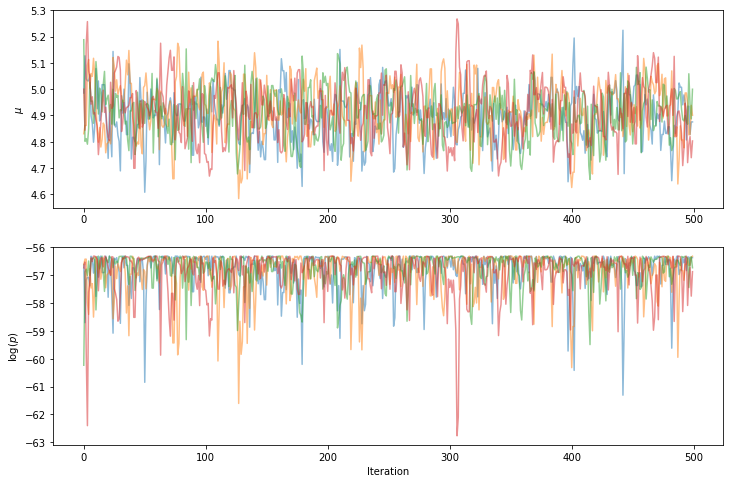

In [13]:
figure(figsize=(12, 8))
mu_ax = subplot(211)
logp_ax = subplot(212)

for j in range(n_ch):
    mu_ax.plot(mu_traces[:, j], alpha=.5)  # alpha to see overlapping traces
mu_ax.set_ylabel('$\mu$')

for j in range(n_ch):
    logp_ax.plot(logp_traces[:, j], alpha=.5)
logp_ax.set_ylabel('$\log(p)$')
logp_ax.set_xlabel('Iteration')

Stan's plot, showing a (marginal) PDF and merged trace plot:

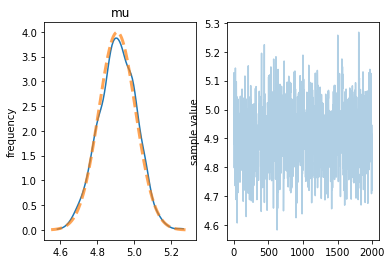

In [14]:
fig = fit.traceplot()
pdf_ax, trace_ax = fig.get_axes()

# Plot analytical PDF on top of Stan's PDF estimate.
mu_l, mu_u = pdf_ax.get_xlim()
mus = linspace(mu_l, mu_u, 250)
pdf = post_pdf.pdf(mus)
pdf_ax.plot(mus, pdf, c='C1', ls='--', lw=3, alpha=.7)

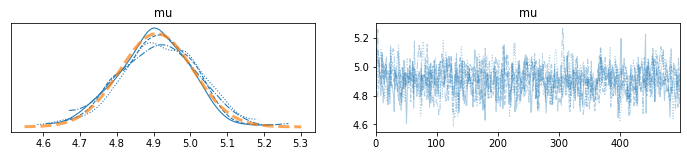

In [15]:
import arviz

pdf_ax, trace_ax = arviz.plot_trace(fit)[0]

# Plot analytical PDF on top of Stan's PDF estimate.
pdf_ax.plot(mus, pdf, c='C1', ls='--', lw=3, alpha=.7)

## Simple tests

Test cases; note they will sometimes (rarely) fail even for correct
code (since they are statistical).  If the 'return' statements are changed to 'assert', these
become valid `pytest` test cases, but `pytest` appears to have issues with PyStan
and/or matplotlib.

In [16]:
def test_post_mean():
    """
    Check that Stan's posterior mean matches the analytical mean to within
    3* the standard error.  This should fail ~< 1% of the time.
    """
    return abs(mu_mean - mu_post) / mu_mean_se < 3.


def test_intvl():
    """
    Check that the true mean is within the 95% interval; this should fail
    5% of the time.
    """
    lo, hi = mu_cr95
    return (mu > lo) and (mu < hi)


def test_Rhat():
    """
    Test that the chain appears to have converged.  This can fail with
    correct code if the chain was not run long enough.
    """
    return abs(Rhat - 1.) < 0.01  # slightly more strict than 0.1 convention


print('********************************')
print('Test results (should be 3*True):\n', test_post_mean(), test_intvl(), test_Rhat())
print('********************************\n')

********************************
Test results (should be 3*True):
 True True True
********************************

